### Characterization of Enamel structure by 4D-STEM

- This is a series of scripts to analyze 4DSTEM data of Enamel samples acquired using K3-IS synchronized with STEMx
- Microscope: JEOL ARM300F operated at 300kV


In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

**DataSet #1**

- Experimental scan dimensions: [133,131,256,256]

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel.dm4'
datacube = py4DSTEM.file.io.read(filename)

Bin(2,2,2, 2) of outer enamel.dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
# Setting scan shapes(need the experimental scan dimensions)
datacube.set_scan_shape(133,131)
datacube.name = 'datacube'

**Generate virtual images**

1. Create virtual masks using average diffraction

<IPython.core.display.Javascript object>


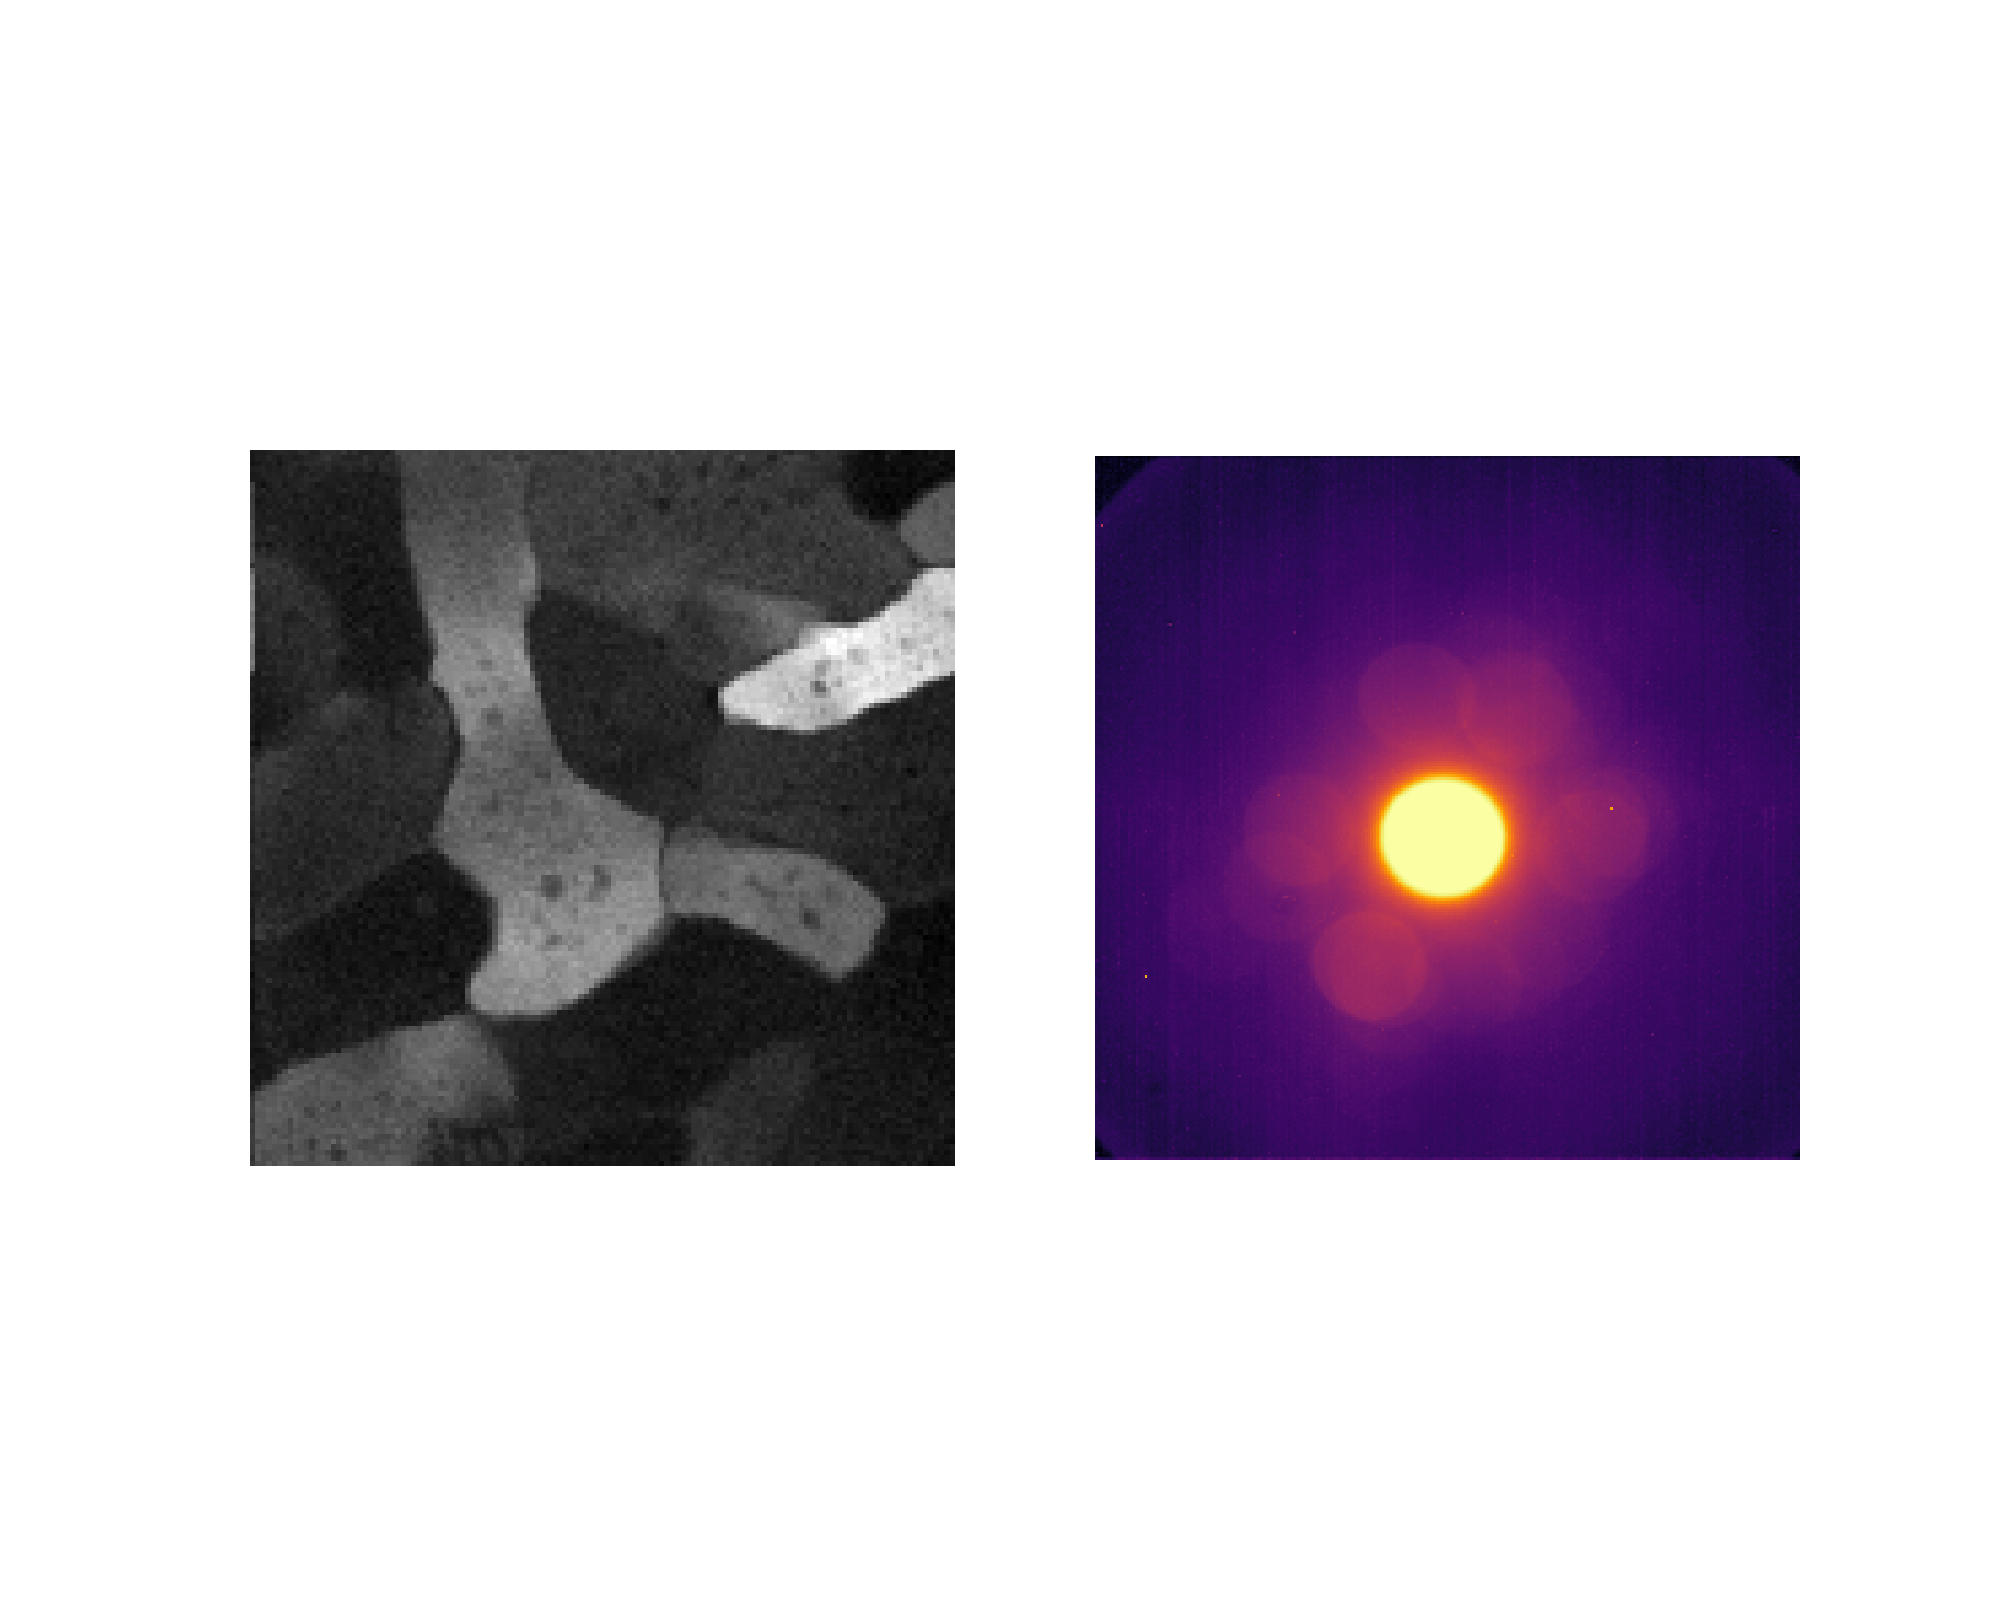

In [4]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,8))

ax1.matshow(np.average(datacube.data, axis=(2,3)))
ax2.matshow(np.sqrt(aveDP), cmap=plt.cm.inferno)

ax1.axis('off')
ax2.axis('off')

plt.show()

In [5]:
from skued.image import powder_center
ic, jc = powder_center(aveDP)

In [6]:
#Prepare BF, ADF masks

# Make a bright field image by centering a circular virtual detector about the unscattered beam
from matplotlib.patches import Rectangle, Circle

detector_radius = 20
qx,qy = ic,jc         # Select center of virtual detector

qx0,qxf = int(qx-detector_radius),int(qx+detector_radius)
qy0,qyf = int(qy-detector_radius),int(qy+detector_radius)



BF = datacube.get_virtual_image_circ_integrate(slice(qx0,qxf),slice(qy0,qyf))[0]
# ABF =
# ADF =


<IPython.core.display.Javascript object>


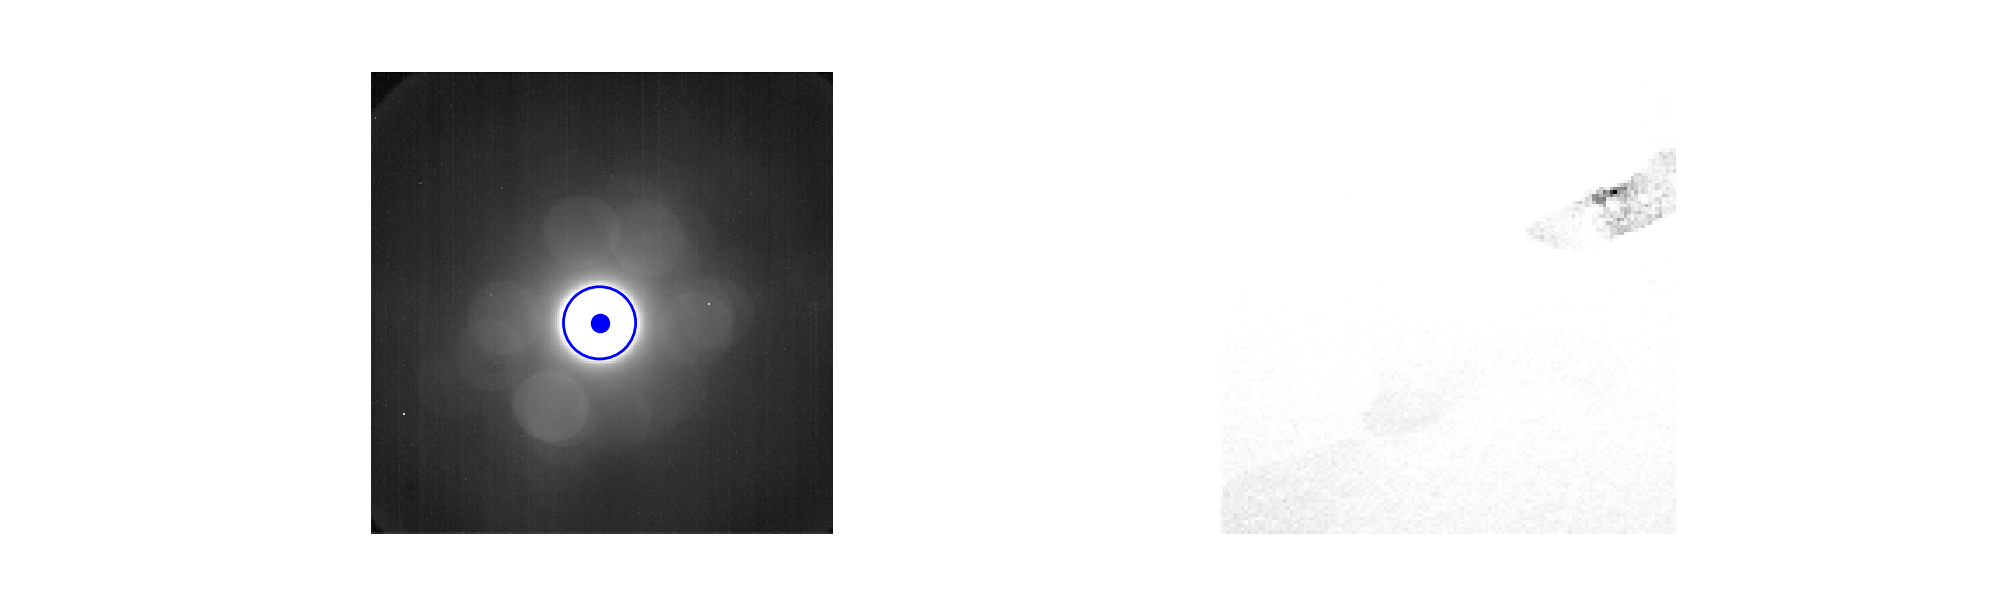

In [7]:
# Show
fig,axs = plt.subplots(1,2,figsize=(10,3))

axs[0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)
axs[1].matshow(BF)

circ = Circle((qy,qx),detector_radius,fill=False,color='b')
axs[0].scatter(qy,qx,color='b')
axs[0].add_patch(circ)


axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [8]:
#check different disks

detector_radius = 20

qx_1,qy_1 = 186,97        # Select center of virtual detector
qx0_1,qxf_1 = int(qx_1-detector_radius),int(qx_1+detector_radius)
qy0_1,qyf_1 = int(qy_1-detector_radius),int(qy_1+detector_radius)

qx_2,qy_2 = 92,153         # Select center of virtual detector
qx0_2,qxf_2 = int(qx_2-detector_radius),int(qx_2+detector_radius)
qy0_2,qyf_2 = int(qy_2-detector_radius),int(qy_2+detector_radius)

qx_3,qy_3 = 134,74         # Select center of virtual detector
qx0_3,qxf_3 = int(qx_3-detector_radius),int(qx_3+detector_radius)
qy0_3,qyf_3 = int(qy_3-detector_radius),int(qy_3+detector_radius)


DF1 = datacube.get_virtual_image_circ_integrate(slice(qx0_1,qxf_1),slice(qy0_1,qyf_1))[0]
DF2 = datacube.get_virtual_image_circ_integrate(slice(qx0_2,qxf_2),slice(qy0_2,qyf_2))[0]
DF3 = datacube.get_virtual_image_circ_integrate(slice(qx0_3,qxf_3),slice(qy0_3,qyf_3))[0]

# ABF =
# ADF =

<IPython.core.display.Javascript object>


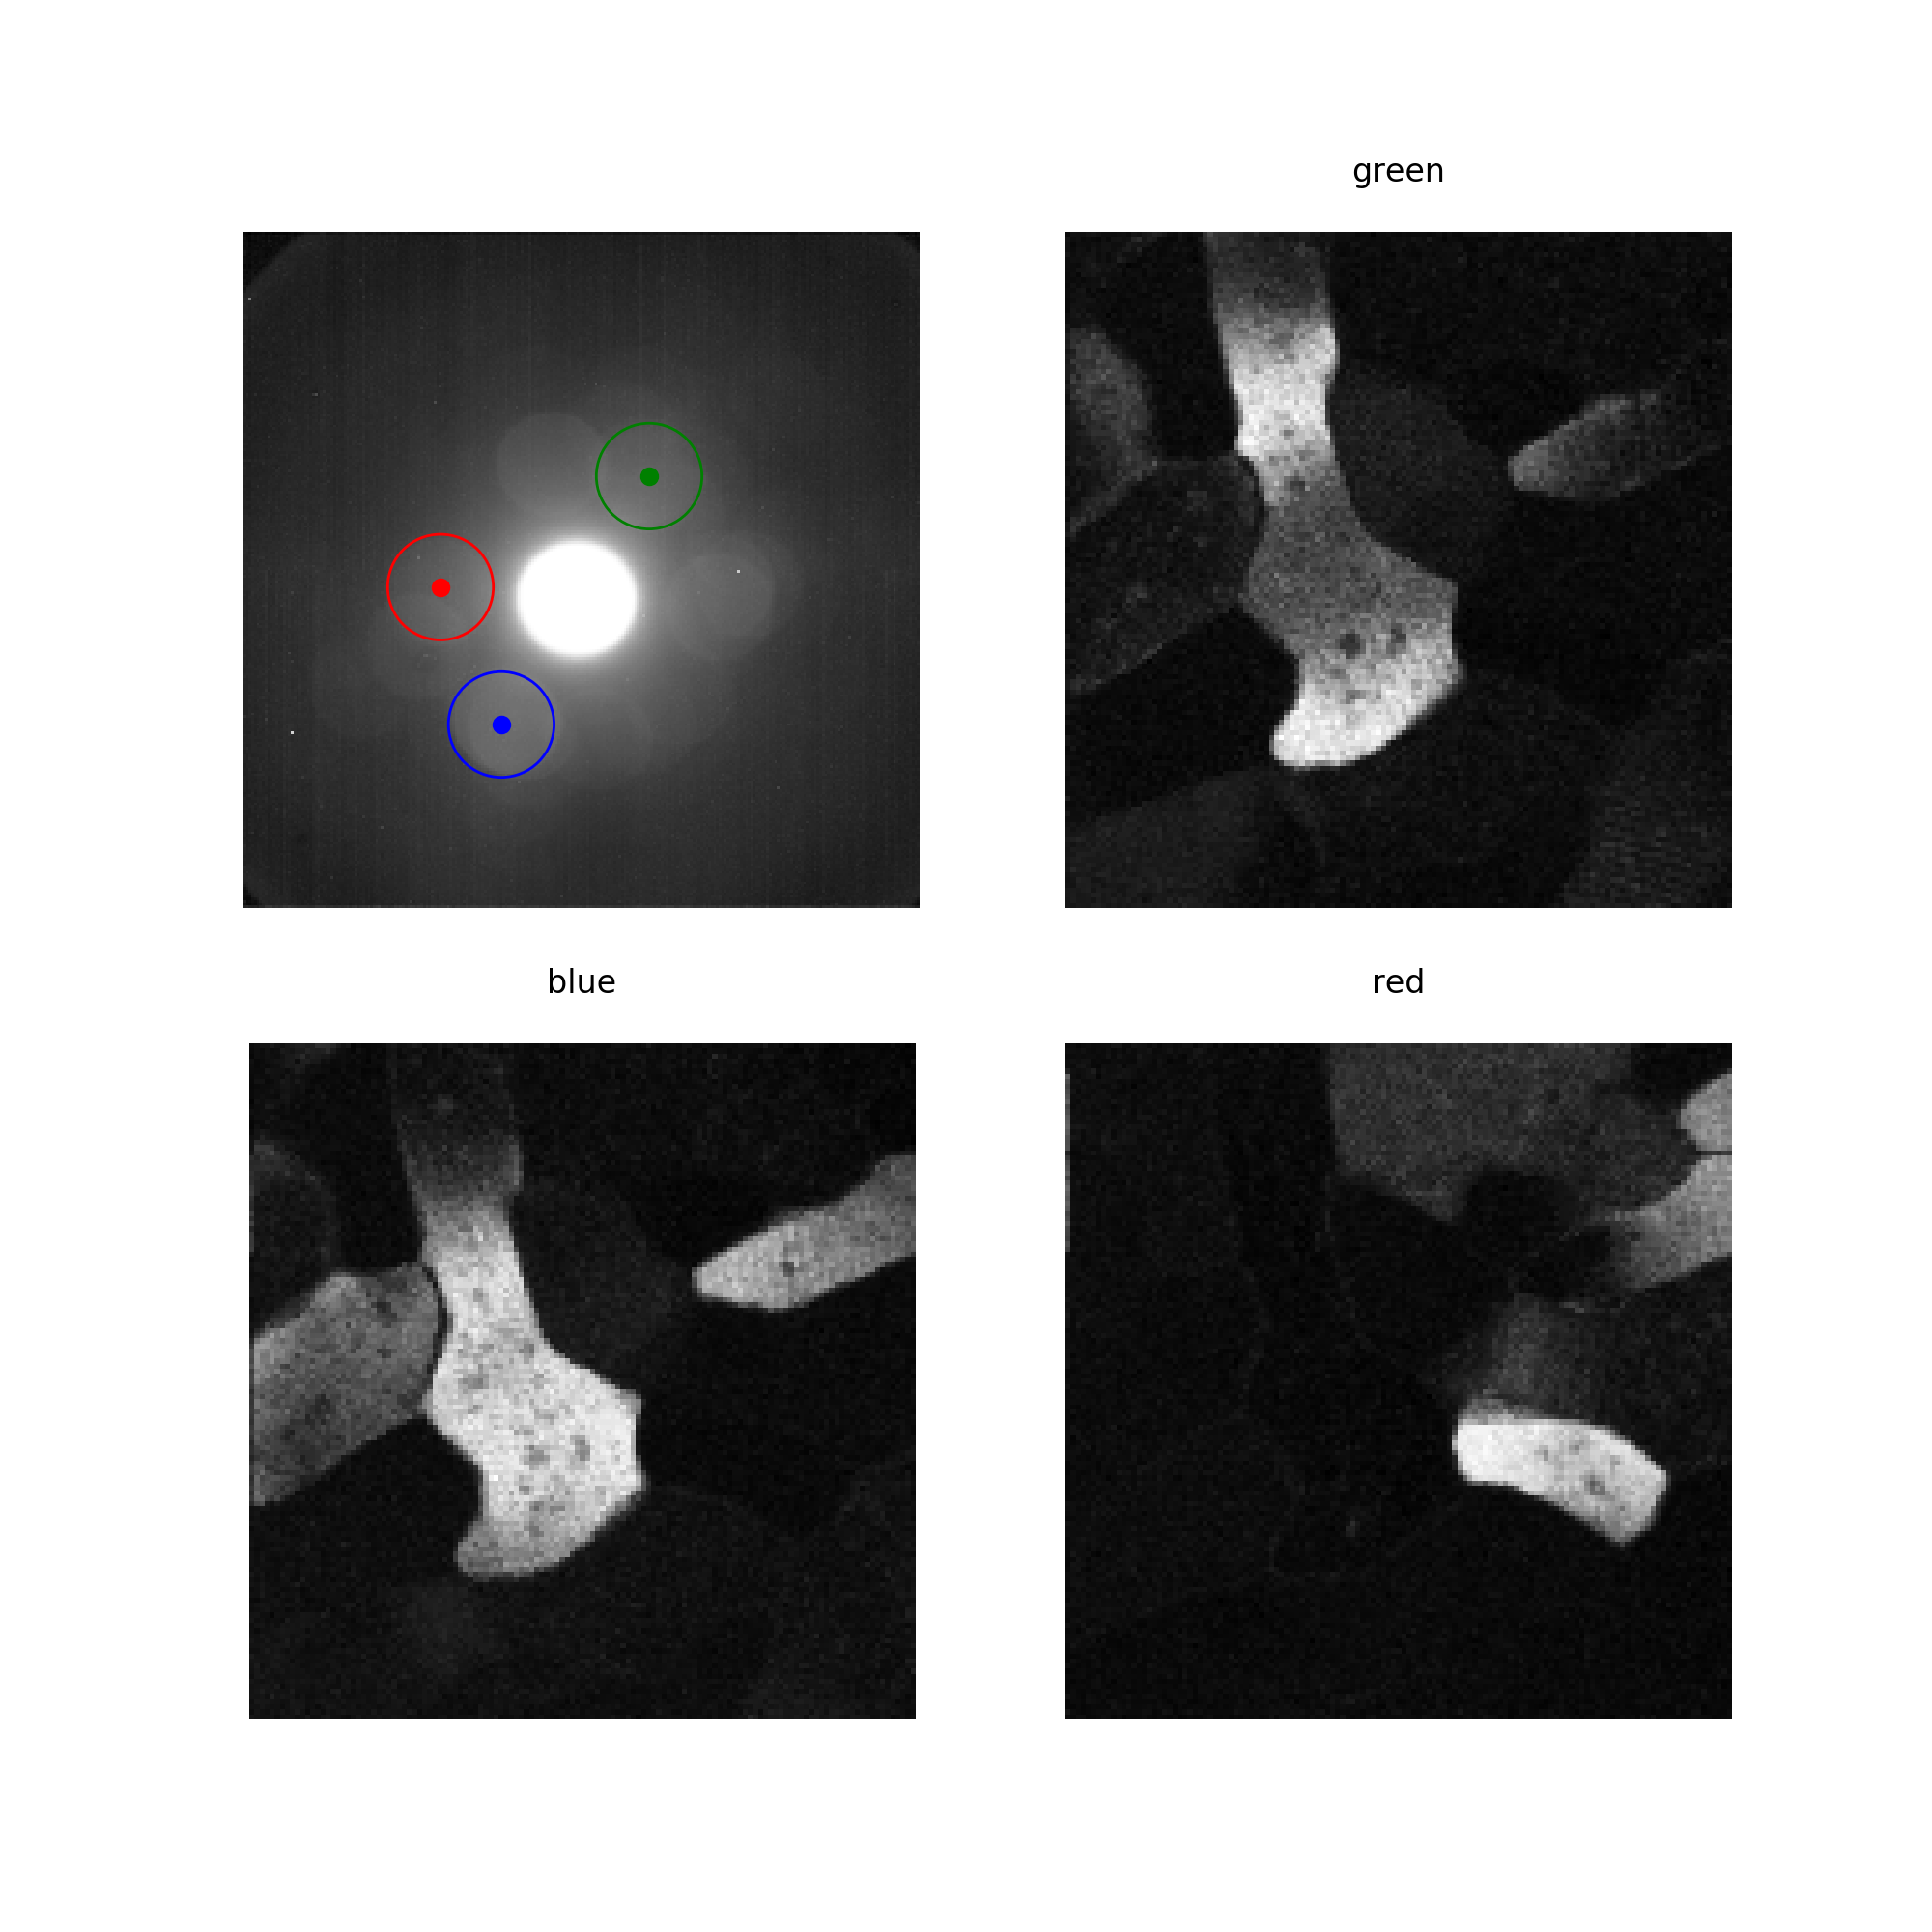

In [9]:

fig,axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((qy_1,qx_1),detector_radius,fill=False,color='b')
axs[0,0].scatter(qy_1,qx_1,color='b')
axs[0,0].add_patch(circ1)

circ2 = Circle((qy_2,qx_2),detector_radius,fill=False,color='g')
axs[0,0].scatter(qy_2,qx_2,color='g')
axs[0,0].add_patch(circ2)

circ3 = Circle((qy_3,qx_3),detector_radius,fill=False,color='r')
axs[0,0].scatter(qy_3,qx_3,color='r')
axs[0,0].add_patch(circ3)

axs[1,0].matshow(DF1)
axs[0,1].matshow(DF2)
axs[1,1].matshow(DF3)

axs[1,0].set_title('blue')
axs[0,1].set_title('green')
axs[1,1].set_title('red')

axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

<IPython.core.display.Javascript object>


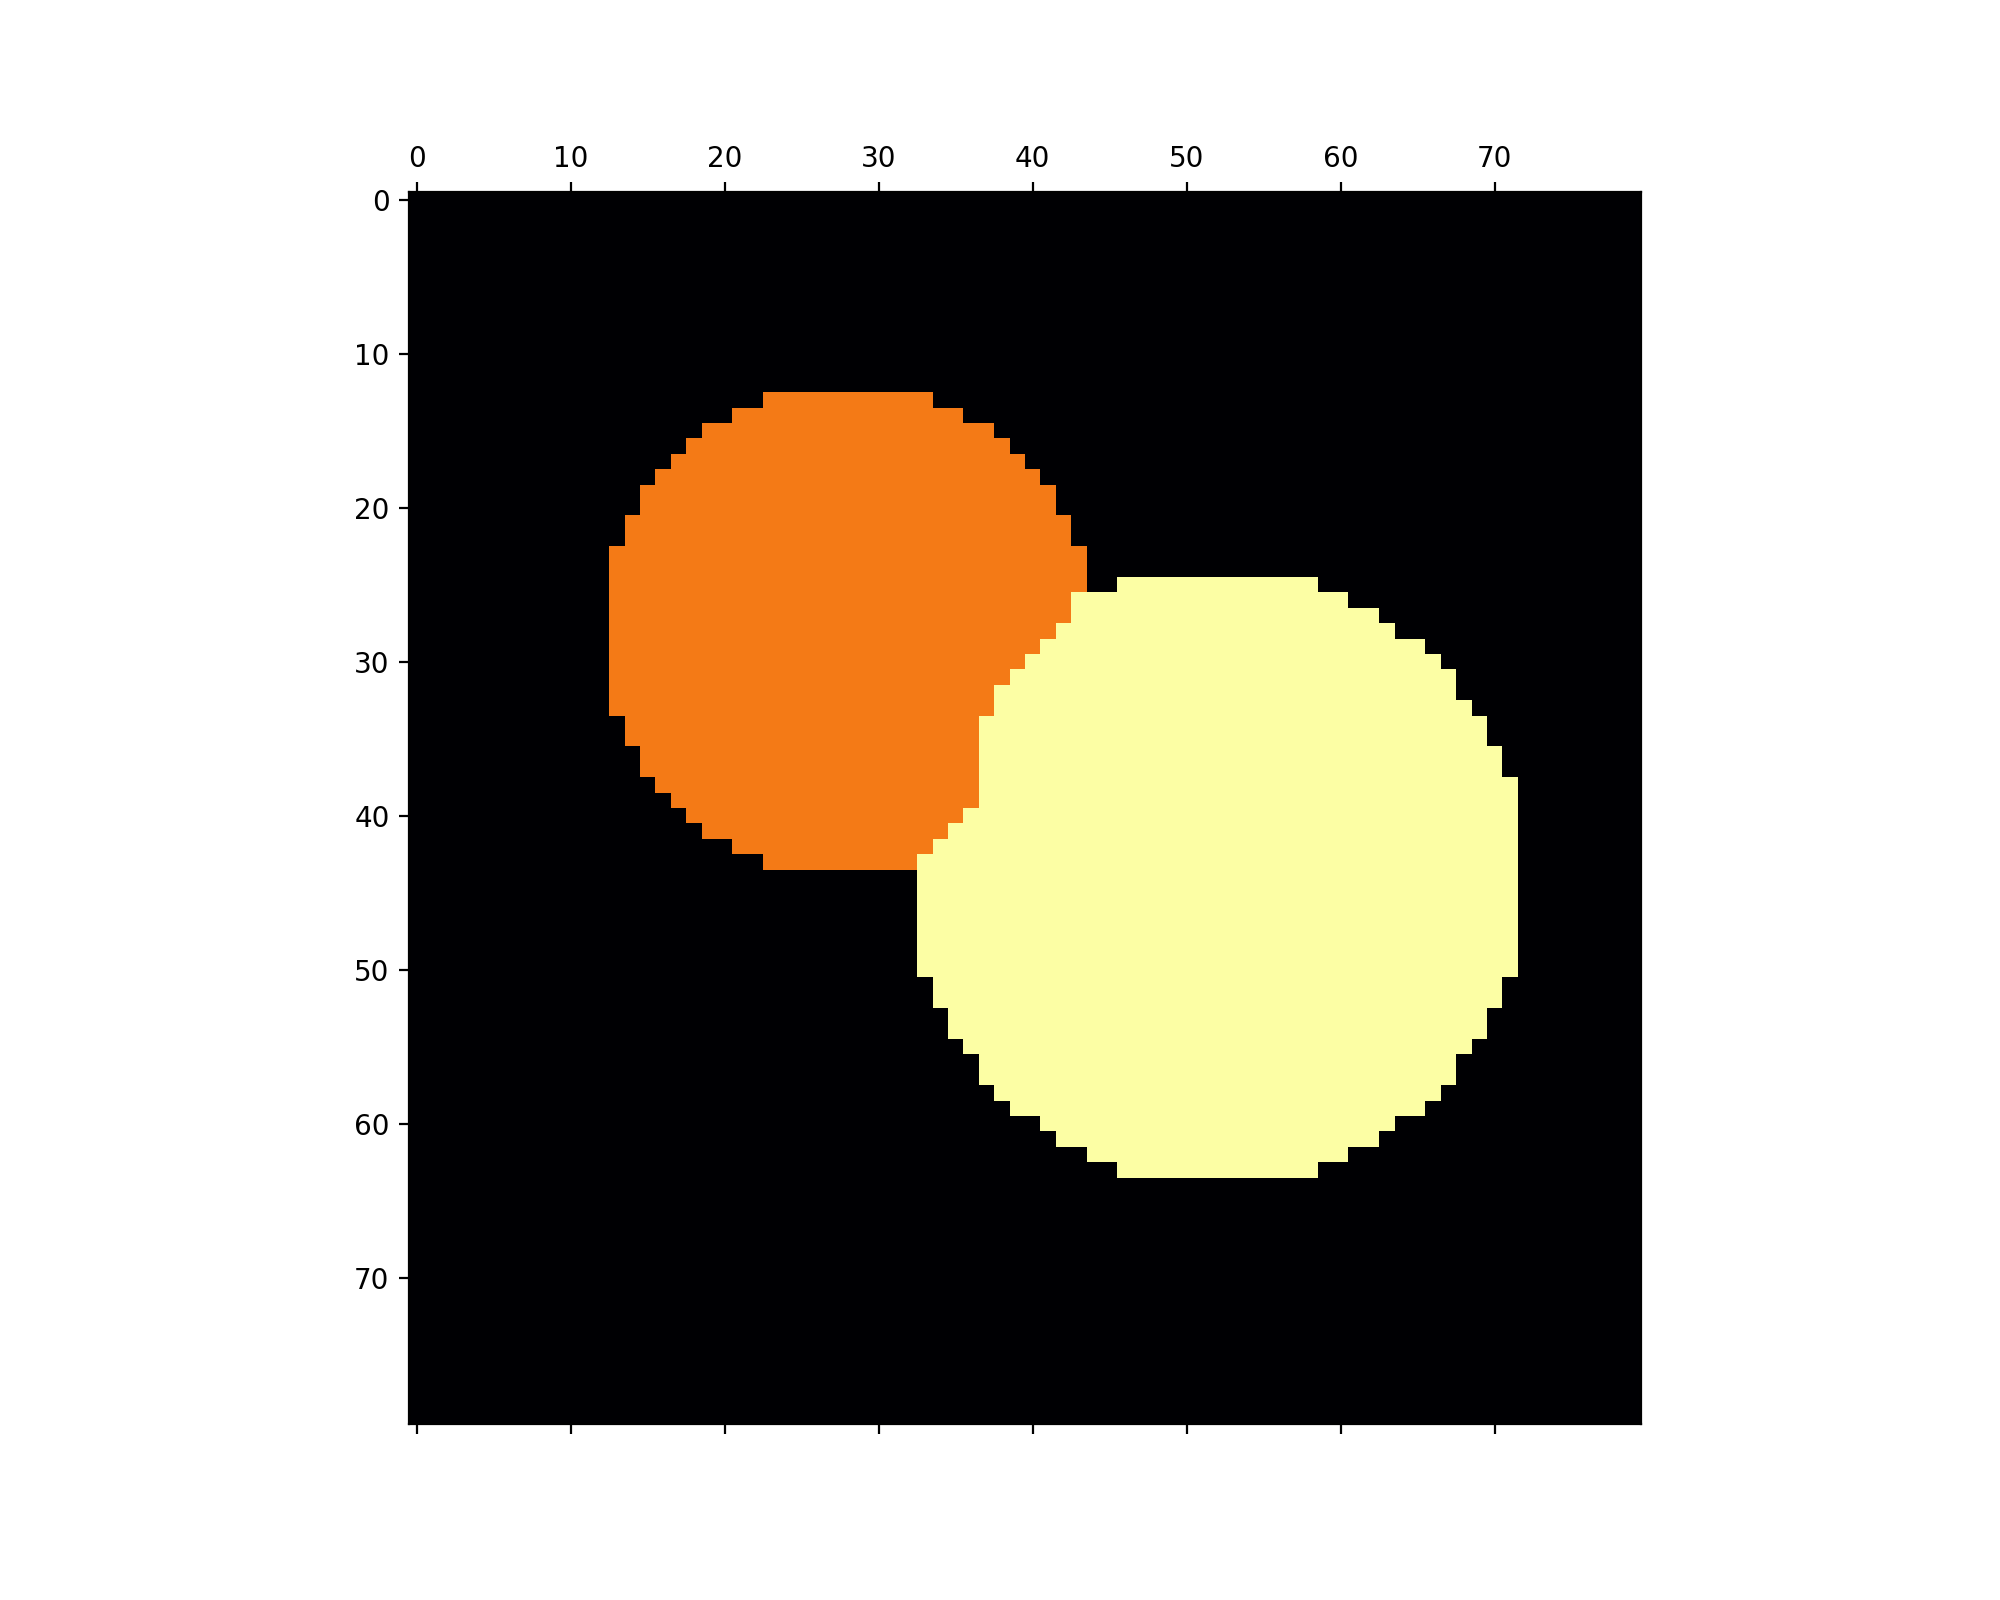

In [10]:
#Segmentation to separate disks
from skimage.morphology import watershed, label
from skimage.feature import peak_local_max

#initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

fig,ax=plt.subplots(figsize=(10,8))
ax.matshow(np.sqrt(labels_ws), cmap=plt.cm.inferno)
plt.show()

In [11]:
aveDP = np.average(datacube.data, axis=(0,1))
#remove center
aveDP[aveDP > 150] = 0
#invert color
aveDP=255-aveDP

<IPython.core.display.Javascript object>


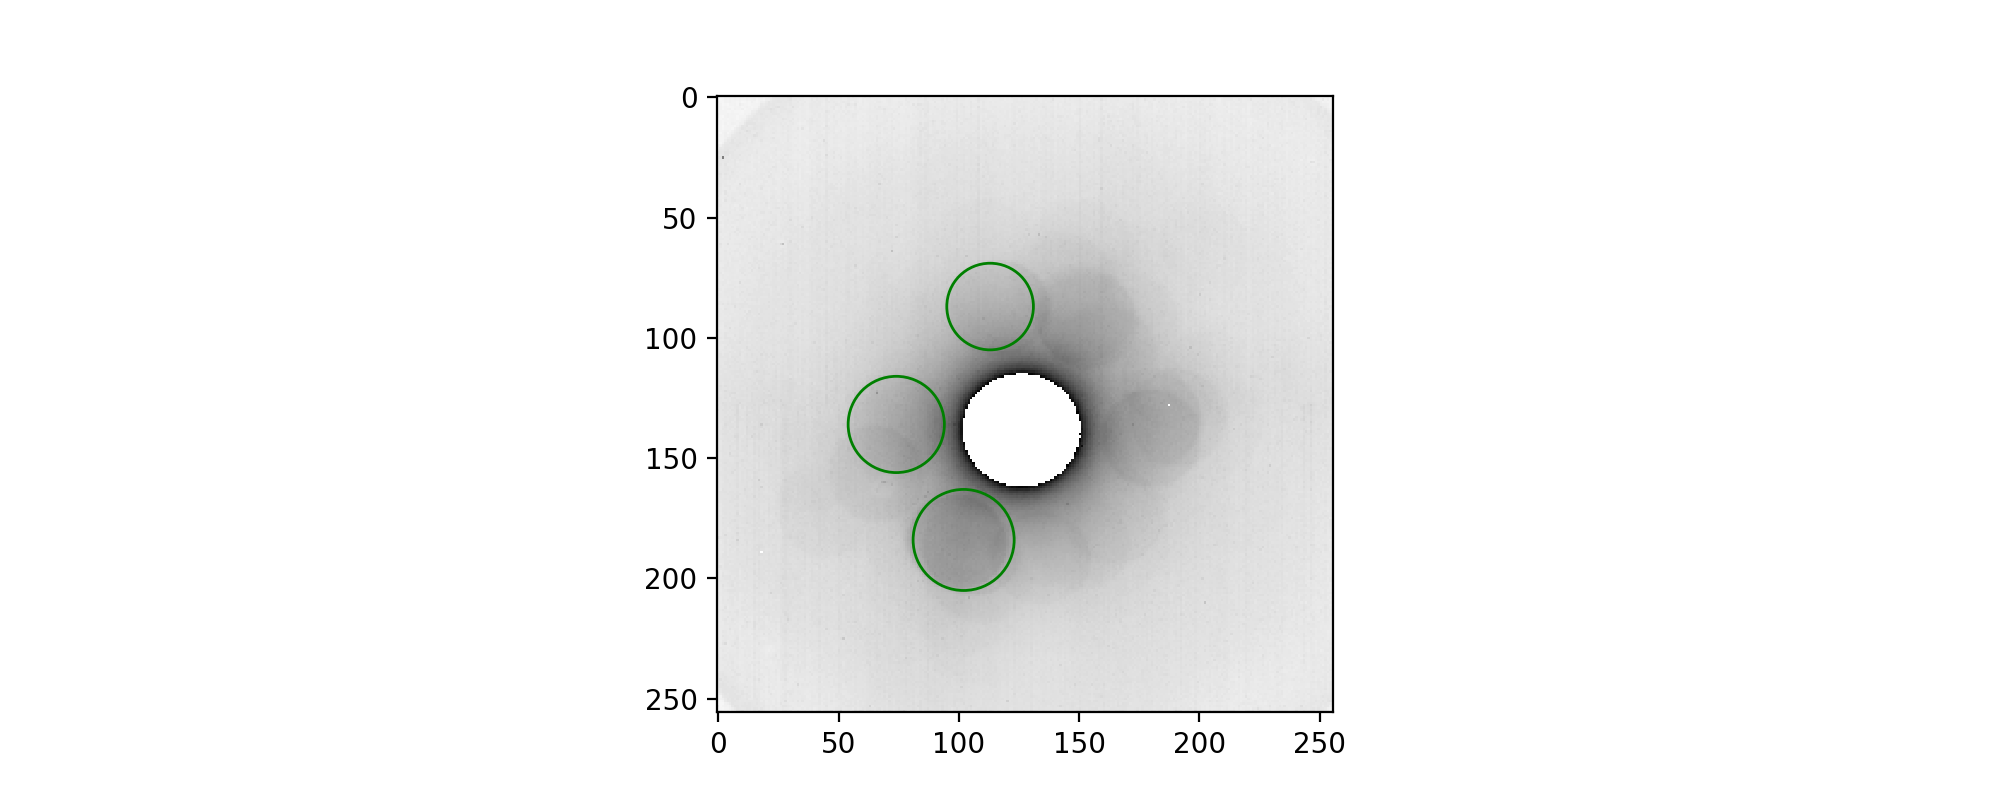

In [12]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter

# Load picture and detect edges


image = aveDP
#edges = canny(image, sigma=0.5, high_threshold=5, low_threshold=3.4)
edges = canny(image, sigma=3)

# Detect two radii
hough_radii = np.arange(16, 22, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3, min_xdistance=20, min_ydistance=20)

# Draw them
fig, ax = plt.subplots(figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    circ = Circle((center_x,center_y),radius,fill=False,color='g')
    ax.add_patch(circ)
ax.imshow(image, cmap=plt.cm.gray)
plt.show()


<IPython.core.display.Javascript object>


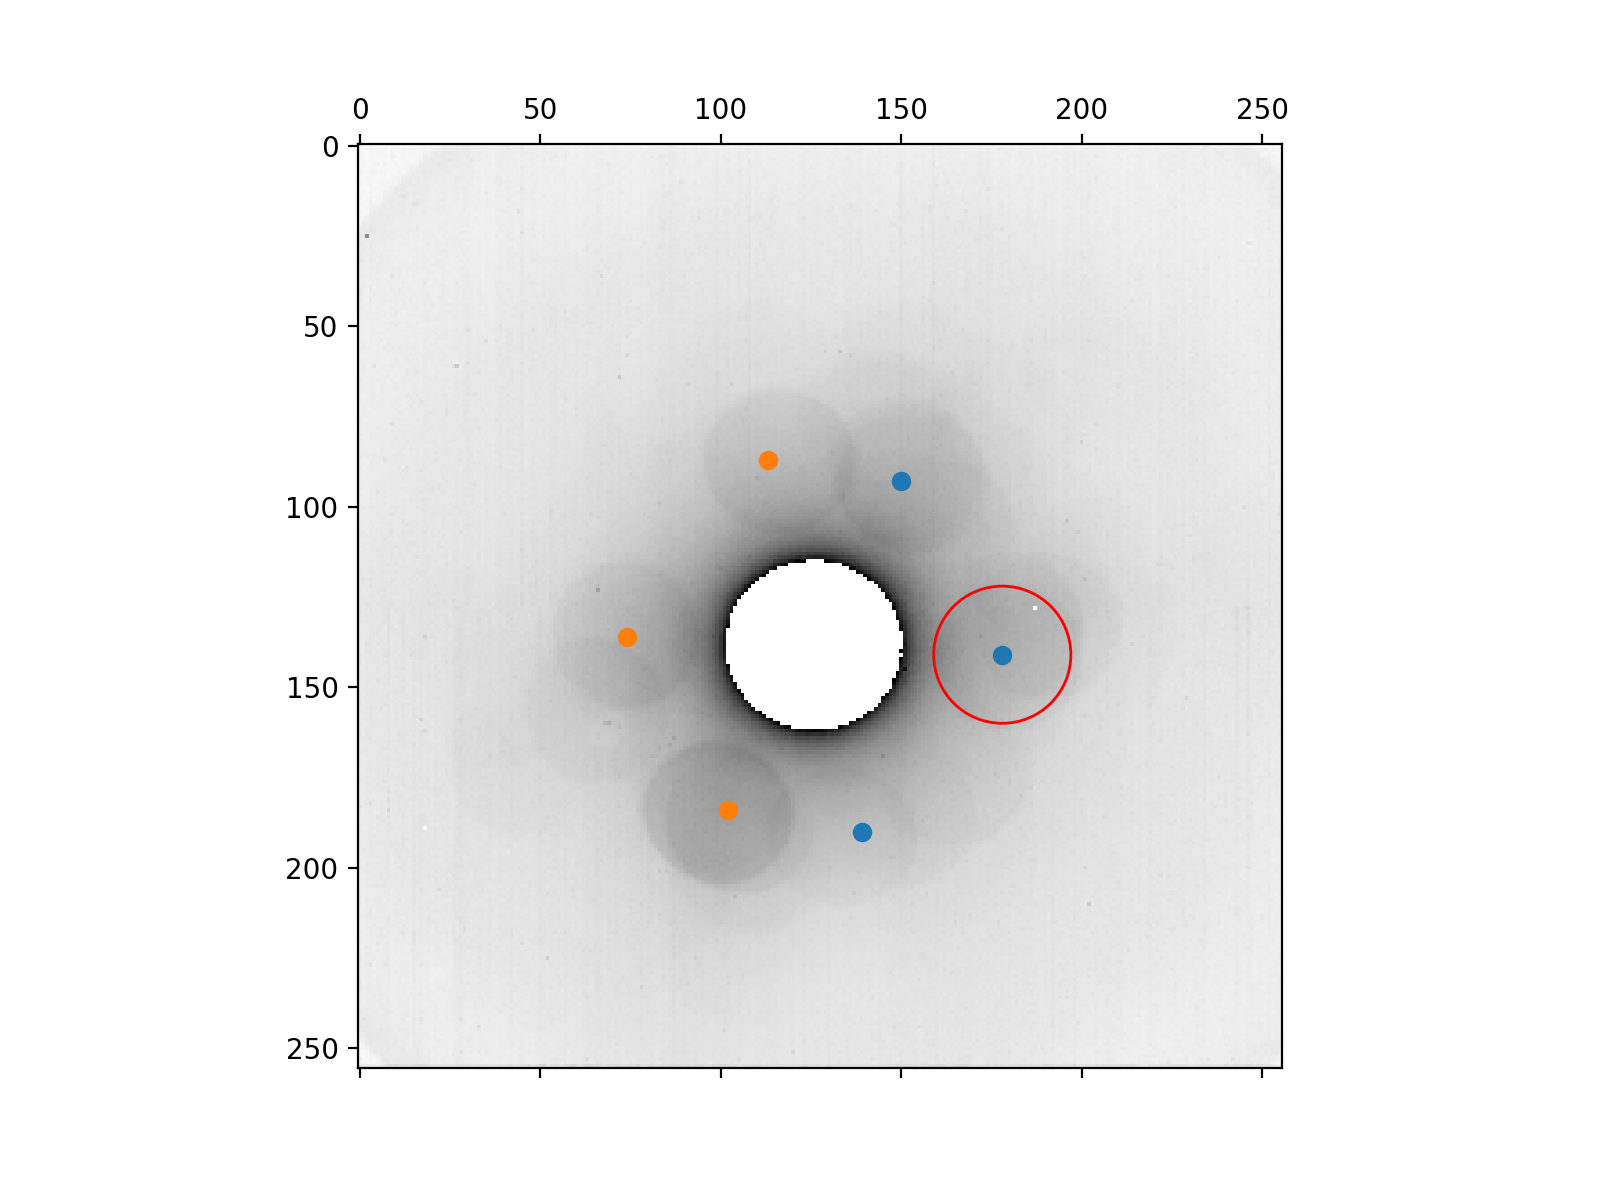

In [13]:
cx_2=-cx+jc*2
cy_2=-cy+ic*2
fig,ax = plt.subplots(figsize=(8,6))

ax.matshow(np.sqrt(aveDP), cmap = plt.cm.gray)
ax.scatter(cx_2,cy_2)
ax.scatter(cx,cy)
circ3 = Circle((cx_2[0],cy_2[0]),19,fill=False,color='r')
ax.add_patch(circ3)


plt.show()

<IPython.core.display.Javascript object>


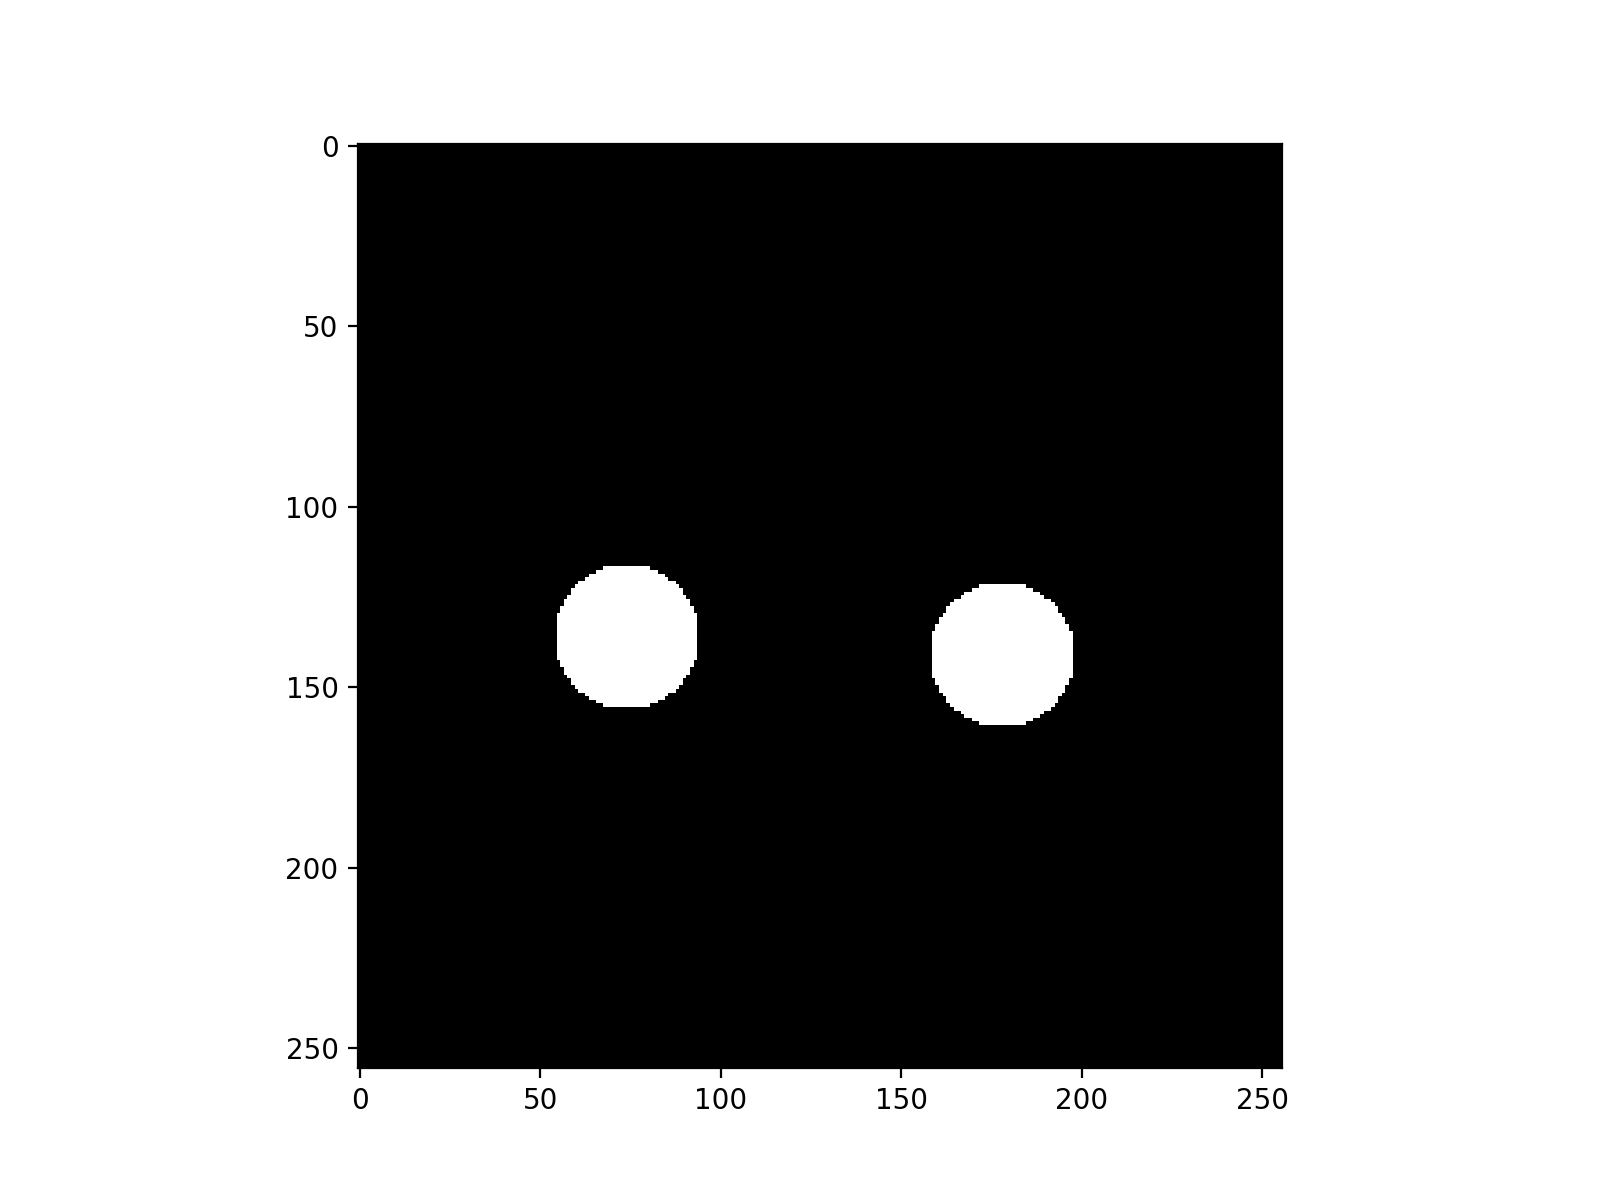

In [14]:
#create a mask for a pair of disks, a pair are diametrically opposed disks 
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle1 = (y - cx[0]) ** 2 + (x - cy[0]) ** 2 < 20 ** 2
mask_circle2 = (y - cx_2[0]) ** 2 + (x - cy_2[0]) ** 2 < 20 ** 2
combine_mask = np.logical_or(mask_circle1, mask_circle2)

fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(combine_mask)
plt.show()

In [15]:
#extract relevant real space data using mask
DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]-1):
    for j in range(0,aveDP.shape[1]-1): 
        if combine_mask[i,j]: 
            DF_real_space=DF_real_space+datacube.data[:,:,i,j] 

<IPython.core.display.Javascript object>


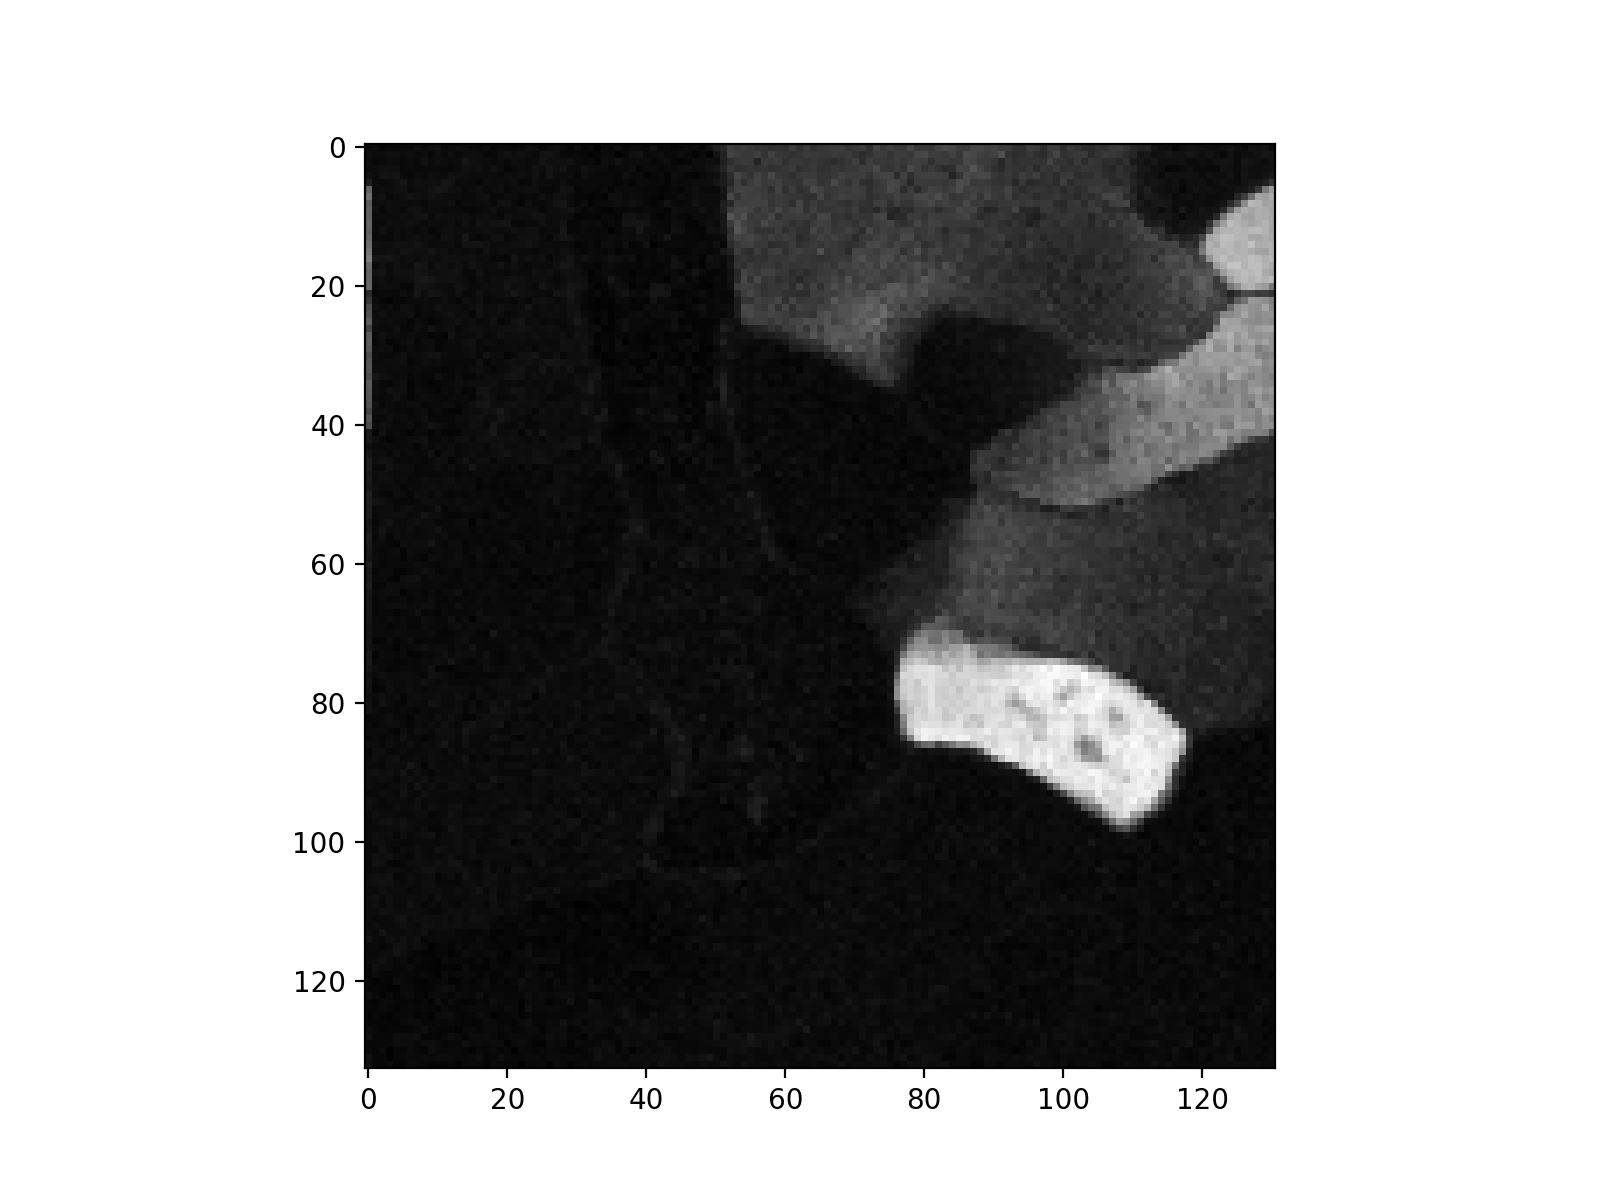

In [16]:
#plot real space grain map
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(DF_real_space)
plt.show()

In [31]:
#let's extract all data simultaneously 
output=[]
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
for k in range(0, len(cx)):
    mask_circle1 = (y - cx[k]) ** 2 + (x - cy[k]) ** 2 < 20 ** 2
    mask_circle2 = (y - cx_2[k]) ** 2 + (x - cy_2[k]) ** 2 < 20 ** 2
    combine_mask = np.logical_or(mask_circle1, mask_circle2)
    
    DF_real_space=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if combine_mask[i,j]: 
                DF_real_space=DF_real_space+datacube.data[:,:,i,j] 
    output.append(DF_real_space)

<IPython.core.display.Javascript object>


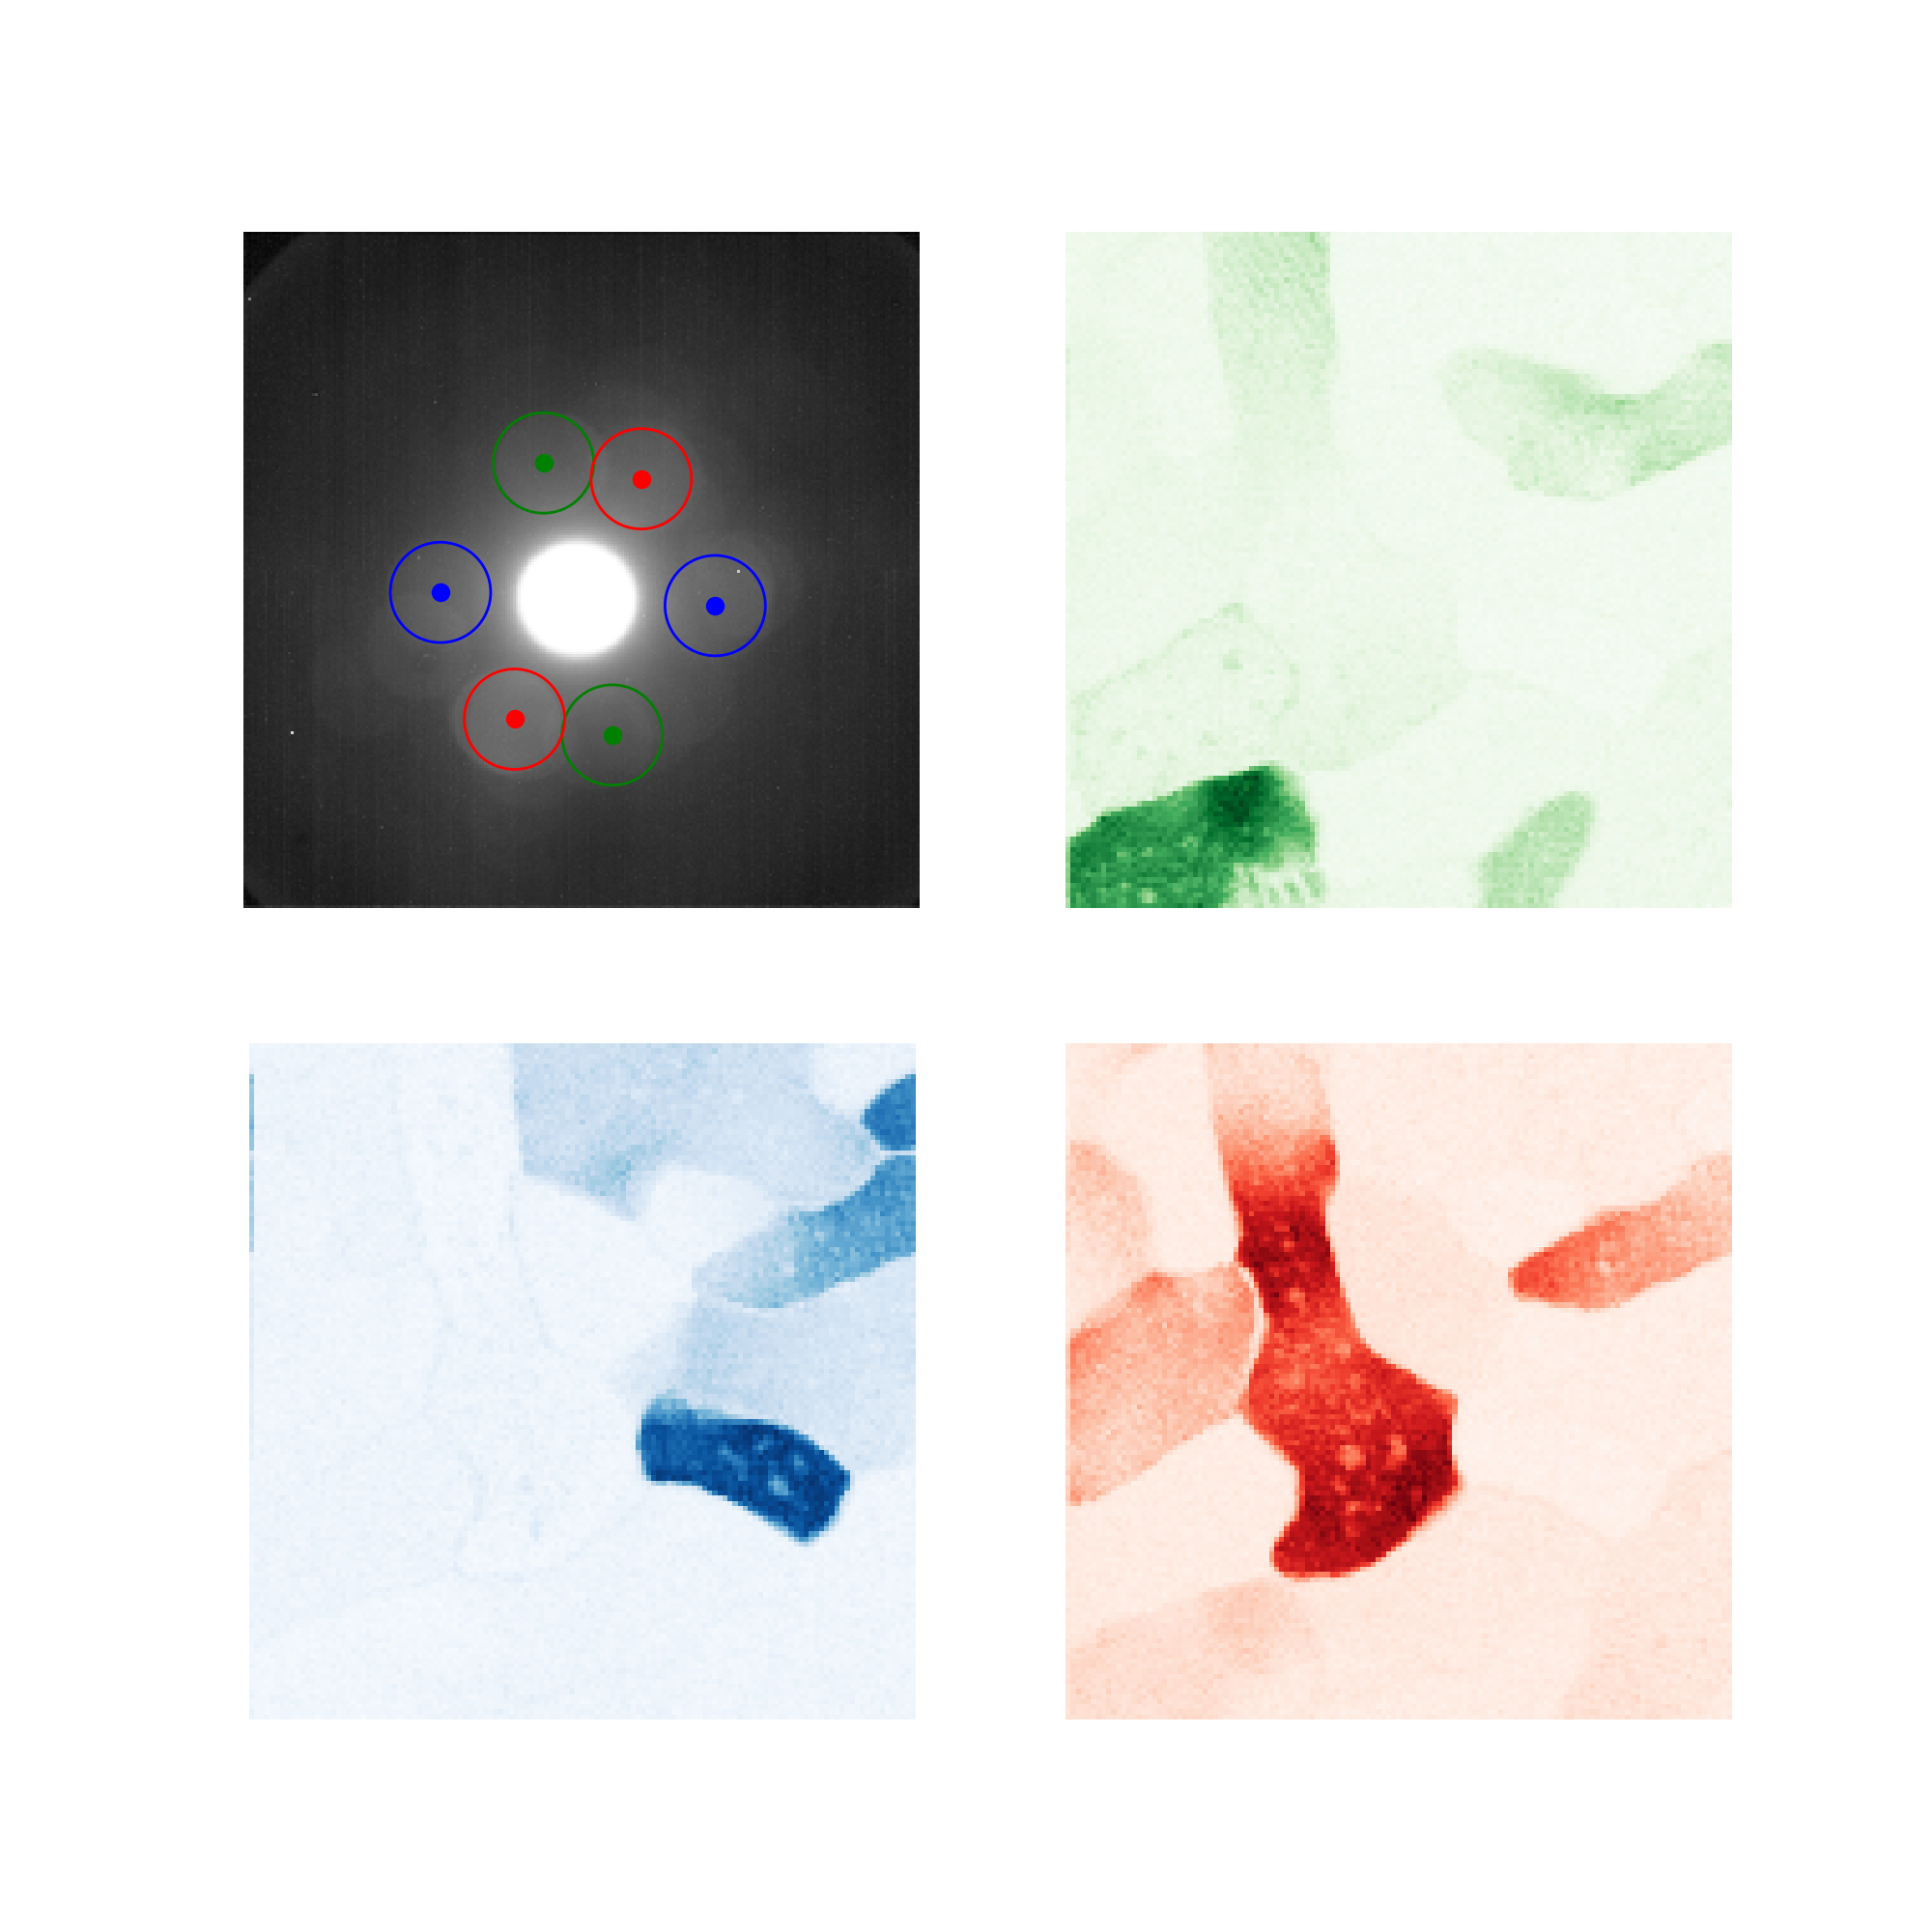

In [33]:
aveDP = np.average(datacube.data, axis=(0,1))

fig,axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].matshow(np.sqrt(aveDP), cmap = plt.cm.gray)

circ1 = Circle((cx[0],cy[0]),19,fill=False,color='b')
axs[0,0].scatter(cx[0],cy[0],color='b')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[0],cy_2[0]),19,fill=False,color='b')
axs[0,0].scatter(cx_2[0],cy_2[0],color='b')
axs[0,0].add_patch(circ1)

circ1 = Circle((cx[1],cy[1]),19,fill=False,color='g')
axs[0,0].scatter(cx[1],cy[1],color='g')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[1],cy_2[1]),19,fill=False,color='g')
axs[0,0].scatter(cx_2[1],cy_2[1],color='g')
axs[0,0].add_patch(circ1)

circ1 = Circle((cx[2],cy[2]),19,fill=False,color='r')
axs[0,0].scatter(cx[2],cy[2],color='r')
axs[0,0].add_patch(circ1)
circ1 = Circle((cx_2[2],cy_2[2]),19,fill=False,color='r')
axs[0,0].scatter(cx_2[2],cy_2[2],color='r')
axs[0,0].add_patch(circ1)

axs[1,0].matshow(output[0], cmap = plt.cm.Blues)
axs[0,1].matshow(output[1], cmap = plt.cm.Greens)
axs[1,1].matshow(output[2], cmap = plt.cm.Reds)

axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')


plt.show()

<IPython.core.display.Javascript object>


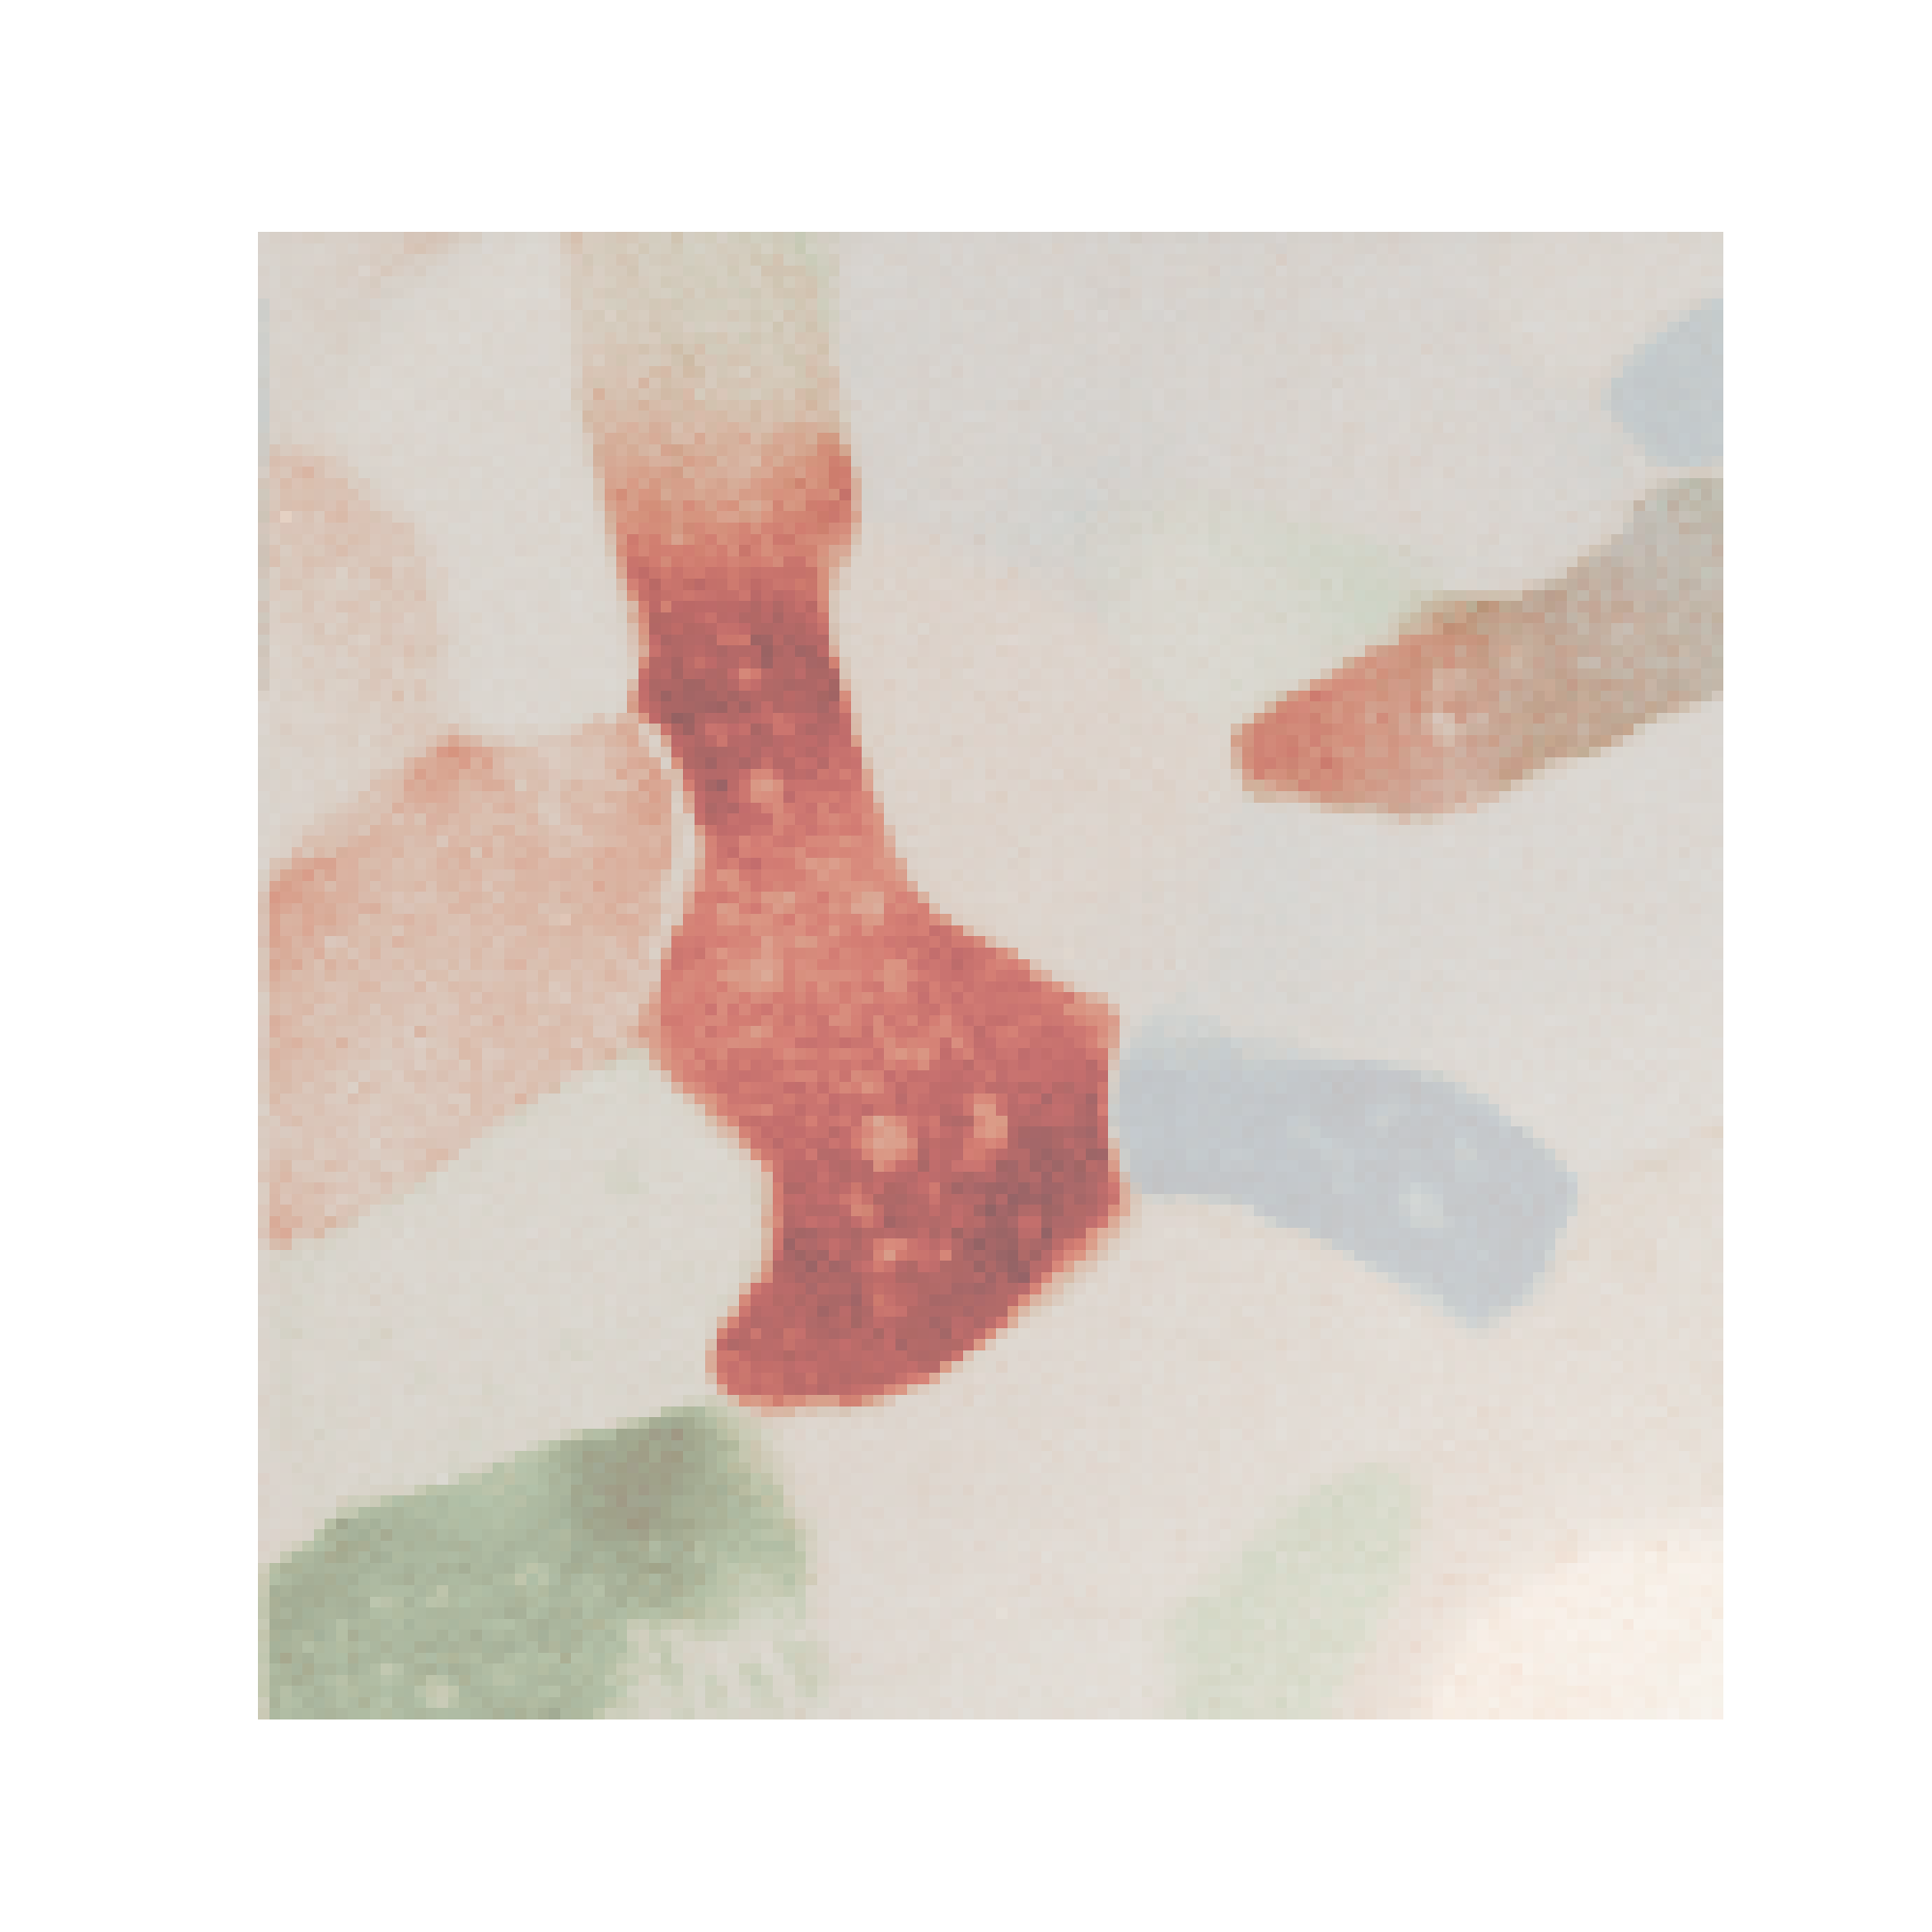

In [35]:
fig,axs = plt.subplots(figsize=(10,10))

axs.matshow(np.sqrt(aveDP), cmap = plt.cm.gray)


axs.matshow(output[0], cmap = plt.cm.Blues, alpha=.5)
axs.matshow(output[1], cmap = plt.cm.Greens, alpha=.5)
axs.matshow(output[2], cmap = plt.cm.Reds, alpha=.5)

axs.axis('off')

plt.show()